In [80]:
import pandas as pd

In [81]:
df = pd.DataFrame()
df = pd.read_csv("train_proper_csv_attack_types.csv",header = None)
df = df.rename(columns=df.iloc[0])
df = df.drop(df.index[0])
df = df.drop('unknown2',axis=1)

C:\Users\Rupesh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [82]:
df1 = pd.DataFrame()
df1 = pd.read_csv("test_proper_csv_attack_types.csv",header = None)
df1 = df1.rename(columns=df1.iloc[0])
df1 = df1.drop(df1.index[0])
df1 = df1.drop('unknown2',axis=1)

C:\Users\Rupesh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
df_tot = pd.concat([df,df1])

In [84]:
def bool_attack(x):
    if(x != "normal"):
        return "attack"
    else:
        return "normal"

In [85]:
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Normalizer

df_tot_1 = df_tot.drop('unknown1',axis=1)
df_output = df_tot['unknown1'].apply(bool_attack)
df_tot_dummies = pd.get_dummies(df_tot_1,columns = ["protocol_type","service","flag"])
x_normalise = Normalizer().fit(df_tot_dummies)
df_tot_dummies = x_normalise.transform(df_tot_dummies)
x_new = SelectFpr(chi2, alpha=0.05).fit_transform(df_tot_dummies, df_output)

In [86]:
import pickle

random_forest_clf = pickle.load(open('dt_test.sav', 'rb'))
AdaBoost_clf = pickle.load(open('AdaBoost_test.sav', 'rb'))
gnb_clf = pickle.load(open('qda_test.sav', 'rb'))

In [87]:
X_train = x_new[:125000]
y_train = df_output.iloc[:125000]
X_test = x_new[125000:]
y_test = df_output.iloc[125000:]

In [88]:
from sklearn.metrics import classification_report

In [89]:
def convert_bool(x):
    if(x == "attack"):
        return 1
    else:
        return 0
    
y_train = y_train.apply(convert_bool)

In [90]:
type(y_train)

pandas.core.series.Series

In [91]:
rf_pred = random_forest_clf.predict(X_train)
rf_conf = random_forest_clf.predict_proba(X_train)
ada_pred = AdaBoost_clf.predict(X_train)
ada_conf = AdaBoost_clf.predict_proba(X_train)
gnb_pred = gnb_clf.predict(X_train)
gnb_conf = gnb_clf.predict_proba(X_train)

In [92]:
conf_vec_list=[]
clf_vec_list=[]
state_vec_list=[]

In [93]:
for i in range(len(rf_pred)):
    tmp1=[]
    tmp1.append(convert_bool(rf_pred[i]))
    tmp1.append(convert_bool(ada_pred[i]))
    tmp1.append(convert_bool(gnb_pred[i]))
    clf_vec_list.append(tmp1)
    state_vec_list.append(tmp1+list(x_new[i]))
    
    tmp1=[]
    tmp1.append(rf_conf[i])
    tmp1.append(ada_conf[i])
    tmp1.append(gnb_conf[i])
    conf_vec_list.append(tmp1)

In [94]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

In [50]:
len(x_new[0])

36

In [95]:
# create model
model = Sequential()
model.add(Dense(150, input_dim=39, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='sigmoid'))

In [96]:
model.predict(np.array(state_vec_list[0:20]))

array([[ 0.51652533,  0.50730032,  0.52471107],
       [ 0.52171743,  0.52207059,  0.53319168],
       [ 0.52255261,  0.50341219,  0.52004844],
       [ 0.50989962,  0.50576389,  0.50727624],
       [ 0.50644499,  0.51983476,  0.52024204],
       [ 0.52189738,  0.504529  ,  0.52155215],
       [ 0.5275383 ,  0.50269812,  0.52143389],
       [ 0.52175057,  0.50477606,  0.52193195],
       [ 0.53508407,  0.49708396,  0.52233303],
       [ 0.52413148,  0.50381833,  0.52114469],
       [ 0.53106529,  0.50082159,  0.52143794],
       [ 0.53085744,  0.50074899,  0.52087164],
       [ 0.51142436,  0.50858873,  0.50840014],
       [ 0.52225256,  0.5094409 ,  0.50651467],
       [ 0.53463477,  0.49931091,  0.52213705],
       [ 0.52000159,  0.50630391,  0.52348077],
       [ 0.5096426 ,  0.50541574,  0.50716054],
       [ 0.52576143,  0.51387858,  0.51024556],
       [ 0.5095526 ,  0.51475346,  0.51597321],
       [ 0.51130772,  0.5135752 ,  0.50999302]], dtype=float32)

In [97]:
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [98]:
input_list = []
output_list = []

In [99]:
def get_rew(qval_v,y,conf_v,clf_v):
    
    act_qval=[]
    
    for j in range(3):
        
        if(y == clf_v[j]):
            #print(qval_v[j])
            #print(conf_v[j]/5)
            tmp = qval_v[j] + conf_v[j][y]/2
            
            if(tmp>1):
                tmp = 0.95

            act_qval.append(tmp)
        else:
            tmp = qval_v[j] - conf_v[j][abs(1-y)]/2
            if(tmp<0):
                tmp = 0.05

            act_qval.append(tmp)
    
    return act_qval

In [100]:
def get_batch(ind_list, input_list, output_list):
    x=[]
    y=[]
    for item in ind_list:
        x.append(input_list[item])
        y.append(output_list[item])
    
    return x,y

In [101]:
import random

for i in range((int)(len(state_vec_list)/10)):
    
    #print("itteration: " + str(i))
    input_list = input_list + state_vec_list[i*10:(i+1)*10]
    Q_val_list = model.predict(np.array(state_vec_list[i*10:(i+1)*10]))
    act_out_list = []
    
    if(i<2):
        print(Q_val_list)
    
    for j in range(len(Q_val_list)):
        #print(conf_vec_list[i*10+j])
        act_out_list.append(get_rew(Q_val_list[j],y_train[i*10+j+1],conf_vec_list[i*10+j],clf_vec_list[i*10+j]))
        
    model.train_on_batch(np.array(state_vec_list[i*10:(i+1)*10]), np.array(act_out_list))
    
    output_list = output_list + act_out_list
    #print(len(input_list))
    #print(len(output_list))
    for j in range(10):
        ind_list = random.sample(range(0, len(input_list)), 10)
        x, y = get_batch(ind_list, input_list, output_list)
        
        model.train_on_batch(np.array(x), np.array(y))

[[ 0.51652533  0.50730032  0.52471107]
 [ 0.52171743  0.52207059  0.53319168]
 [ 0.52255261  0.50341219  0.52004844]
 [ 0.50989962  0.50576389  0.50727624]
 [ 0.50644499  0.51983476  0.52024204]
 [ 0.52189738  0.504529    0.52155215]
 [ 0.5275383   0.50269812  0.52143389]
 [ 0.52175057  0.50477606  0.52193195]
 [ 0.53508407  0.49708396  0.52233303]
 [ 0.52413148  0.50381833  0.52114469]]
[[ 0.54228497  0.73561305  0.52210623]
 [ 0.54177892  0.73522663  0.52151543]
 [ 0.53825611  0.67588812  0.49891946]
 [ 0.5539816   0.71262491  0.5154621 ]
 [ 0.54435372  0.7335422   0.52184814]
 [ 0.53665036  0.74135393  0.5220238 ]
 [ 0.53574556  0.67021167  0.49530187]
 [ 0.53287339  0.73630852  0.51446784]
 [ 0.53861952  0.68223387  0.50847352]
 [ 0.54015726  0.68303818  0.50103658]]


In [58]:
from keras.models import model_from_json
model_json = model.to_json()
with open("model_qda_ada_knn.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_ada_dt_knn.h5")
print("Saved model to disk")



Saved model to disk


In [ ]:
# Fit the model
model.fit(np.array(state_vec_list), np.array(y_train), epochs=30, batch_size=10)

In [18]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")

In [33]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [102]:
rf_pred_ts = random_forest_clf.predict(X_test)
rf_conf_ts = random_forest_clf.predict_proba(X_test)
ada_pred_ts = AdaBoost_clf.predict(X_test)
ada_conf_ts = AdaBoost_clf.predict_proba(X_test)
gnb_pred_ts = gnb_clf.predict(X_test)
gnb_conf_ts = gnb_clf.predict_proba(X_test)

In [103]:
conf_vec_list_ts=[]
clf_vec_list_ts=[]
state_vec_list_ts=[]

In [104]:
for i in range(len(rf_pred_ts)):
    tmp1=[]
    tmp1.append(convert_bool(rf_pred_ts[i]))
    tmp1.append(convert_bool(ada_pred_ts[i]))
    tmp1.append(convert_bool(gnb_pred_ts[i]))
    clf_vec_list_ts.append(tmp1)
    state_vec_list_ts.append(tmp1+list(X_test[i]))
    
    tmp1=[]
    tmp1.append(rf_conf_ts[i])
    tmp1.append(ada_conf_ts[i])
    tmp1.append(gnb_conf_ts[i])
    conf_vec_list_ts.append(tmp1)

In [105]:
input_list_ts = []
output_list_ts = []
pred_list = []

In [106]:
input_vec = []


In [107]:
for i in range(len(rf_pred_ts)):
    tmp1=[]
    tmp1.append(convert_bool(rf_pred_ts[i]))
    tmp1.append(convert_bool(ada_pred_ts[i]))
    tmp1.append(convert_bool(gnb_pred_ts[i]))
    input_vec.append(tmp1+list(X_test[i]))
    
y_test = np.array(y_test.apply(convert_bool))

In [28]:
(int)(len(state_vec_list_ts)/10)

2351

In [32]:
import copy

In [108]:
import random

for i in range((int)(len(state_vec_list_ts)/10)):
    
    print("itteration: " + str(i))
    input_list_ts = input_list_ts + state_vec_list_ts[i*10:(i+1)*10]
    Q_val_list = model.predict(np.array(state_vec_list_ts[i*10:(i+1)*10]))
    
    if(i%50 == 0):
        print(Q_val_list)
    
    for i in range(len(Q_val_list)):
        pred_list.append(Q_val_list[i])
        
    #scores = model.test_on_batch(np.array(state_vec_list_ts[i*10:(i+1)*10]), np.array(act_out_list))
    #print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    act_out_list = []
    
    for j in range(len(Q_val_list)):
        #print(conf_vec_list[i*10+j])
        act_out_list.append(get_rew(Q_val_list[j],y_test[i*10+j+1],conf_vec_list_ts[i*10+j],clf_vec_list_ts[i*10+j]))
        
    model.train_on_batch(np.array(state_vec_list_ts[i*10:(i+1)*10]), np.array(act_out_list))
    
    output_list_ts = output_list_ts + act_out_list
    #print(len(input_list))
    #print(len(output_list))
    for j in range(10):
        ind_list = random.sample(range(0, len(input_list_ts)), 10)
        x, y = get_batch(ind_list, input_list_ts, output_list_ts)
        
        model.train_on_batch(np.array(x), np.array(y))

itteration: 0
[[ 0.52451098  0.94982934  0.52376783]
 [ 0.51575977  0.95092911  0.53673738]
 [ 0.5298456   0.94982356  0.51807696]
 [ 0.52784806  0.94940525  0.53508836]
 [ 0.52442354  0.95072955  0.51634699]
 [ 0.52423137  0.95131195  0.52042413]
 [ 0.51132172  0.9501645   0.52941877]
 [ 0.53334808  0.95042694  0.51789343]
 [ 0.52699786  0.95006323  0.50630867]
 [ 0.52653575  0.94939172  0.53529119]]
itteration: 1
itteration: 2
itteration: 3
itteration: 4
itteration: 5
itteration: 6
itteration: 7
itteration: 8
itteration: 9
itteration: 10
itteration: 11
itteration: 12
itteration: 13
itteration: 14
itteration: 15
itteration: 16
itteration: 17
itteration: 18
itteration: 19
itteration: 20
itteration: 21
itteration: 22
itteration: 23
itteration: 24
itteration: 25
itteration: 26
itteration: 27
itteration: 28
itteration: 29
itteration: 30
itteration: 31
itteration: 32
itteration: 33
itteration: 34
itteration: 35
itteration: 36
itteration: 37
itteration: 38
itteration: 39
itteration: 40
itte

In [66]:
len(pred_list)

23510

In [130]:
def pred(y_pred):
    
    y_pred_1=[]
    for k in range(len(y_pred)):
        ac=0
        nc=0
        
        if(y_pred[k][1] > 0.7):
            y_pred_1.append(convert_bool(ada_pred_ts[k]))
            continue
        else:
            if(y_pred[k][0] > float(0.5)):
                if(convert_bool(rf_pred_ts[k]) == 1):
                    ac = ac+1
                else:
                    nc = nc+1

            if(y_pred[k][1] > float(0.6)):
                if(convert_bool(ada_pred_ts[k]) == 1):
                    ac = ac+1
                else:
                    nc = nc+1

            if(y_pred[k][2] > float(1)):
                if(convert_bool(gnb_pred_ts[k]) == 1):
                    ac = ac+1
                else:
                    nc = nc+1

            print(ac-nc)
            if(ac > nc):
                y_pred_1.append(1)
            else:
                y_pred_1.append(0)

    return y_pred_1

In [131]:
pred_out = pred(pred_list)

-2
-2
2
-2
1
-2
-2
-2
-2
-2
1
-2
-2
-2
-2
1
-2
-2
1
-2
-2
1
-2
-2
-2
-2
-2
1
-2
1
-2
-2
-2
-2
-2
1
-2
1
-2
-2
-2
2
-1
-2
-2
1
-2
-2
-2
-2
-2
-1
-1
-2
-1
-1
-2
-1
-1
-1
-2
-2
-2
-2
-2
-2
-2
-1
-2
-2
-2
-2
-2
-1
2
1
-2
2
-1
-2
-2
2
-2
-2
-2
2
-2
-2
-2
-2
1
-1
1
2
-2
-2
-2
1
-2
-2
-2
-2
-2
-1
-2
-1
1
-2
1
1
-2
2
-2
2
-1
1
-2
-1
1
-2
1
-2
-1
-1
-1
-2
-1
-2
-2
-1
-1
1
-2
-2
-2
-2
1
1
-2
1
-2
-2
-2
-1
-2
-1
-2
-1
-1
-1
-2
2
-2
-2
2
-1
-2
1
-2
-2
1
-1
-2
-2
-1
-2
-1
-2
-1
-2
-2
1
-2
2
-2
-2
-1
-1
-2
-2
-2
2
1
-1
-1
-2
-2
-2
-1
-2
-2
-2
-2
-2
-2
-1
-2
-1
-2
-2
-1
-2
-2
2
1
-2
-1
-1
-1
-1
-1
-1
-1
-2
1
-2
-2
-2
-2
-2
-1
-1
-2
-2
-1
2
1
-2
2
-2
-2
1
-2
1
1
2
-2
2
1
-2
1
-2
-2
-1
-2
-2
-1
-1
1
-2
-1
-2
-2
-2
1
-2
-2
-2
2
-2
-2
-2
-2
1
-1
-2
-2
-2
-2
-2
-2
2
-2
-2
-2
-2
-2
-2
-2
-2
-1
-2
-1
-1
-2
-2
2
-2
-2
-2
-2
-2
-2
-1
-1
-2
-1
-2
-2
-2
1
-2
-2
-1
-2
2
-1
-2
-2
-1
-2
-2
-2
-2
-1
-2
-2
-2
-1
-2
1
-1
-2
-2
-2
-2
-2
1
-1
1
1
-2
-2
-1
-1
-2
2
-1
1
-1
-1
-2
-1
-2
-2
-2
-2
-2
-1
1
-2
-2
-2
-2
-2
-2
-

In [68]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [69]:
def cal_fpr_acc(TP,FP,TN,FN):
    acc = (TP+TN)/(TP+TN+FP+FN)
    fpr = (FP)/(FP+TN)
    
    return fpr, acc

In [132]:
params = list(perf_measure(np.array(y_test),np.array(pred_out)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

(0.0263671875, 0.8019566142067206)

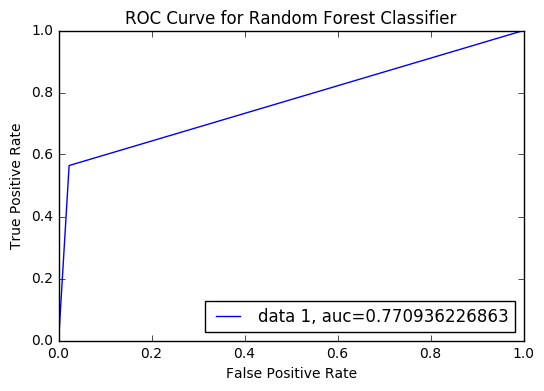

In [40]:
from sklearn import metrics as mt
import matplotlib.pyplot as plt

fpr, tpr, _ = mt.roc_curve(np.array(y_test[:23510]),np.array(pred_out))
auc = mt.roc_auc_score(np.array(y_test[:23510]),np.array(pred_out))
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc=4)
plt.show()

In [38]:
ada_pred_ts

array(['attack', 'normal', 'attack', ..., 'attack', 'normal', 'attack'], dtype=object)

In [26]:
y_pred = model.predict(np.array(input_vec))

In [39]:
print(rf_pred_ts[0])
print(ada_pred_ts[0])
print(svc_pred_ts[0])
print(y_pred[0])

attack
attack
attack
[ 0.56398749  0.95026147  0.95035213]


In [71]:
params = list(perf_measure(np.array(y_test),y_pred_1))
cal_fpr_acc(params[0],params[1],params[2],params[3])

(0.026164209704188226, 0.8107671372682429)

In [40]:
# evaluate the model
scores = model.evaluate(np.array(input_vec), y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

23264/23516 [============================>.] - ETA: 0s
acc: 81.07%


In [41]:
from sklearn.metrics import confusion_matrix

In [47]:
y_pred = model.predict(np.array(input_vec))



In [49]:
perf_measure(np.array(y_test),y_pred)

(7151, 232, 9348, 3642)

In [72]:
model.predict(np.array(state_vec_list[30:50]))

array([[ 0.49379888,  0.51082659,  0.51272684],
       [ 0.51646125,  0.51173252,  0.51172727],
       [ 0.50007522,  0.51096559,  0.51643753],
       [ 0.52758455,  0.51031613,  0.51599085],
       [ 0.5219447 ,  0.52923155,  0.52078563],
       [ 0.50418401,  0.51036888,  0.51245952],
       [ 0.52472532,  0.5320242 ,  0.52261877],
       [ 0.51225716,  0.50348294,  0.51836002],
       [ 0.51284444,  0.51388341,  0.50931829],
       [ 0.51534176,  0.50153255,  0.51836681],
       [ 0.51829606,  0.51138997,  0.51156992],
       [ 0.51935685,  0.49886343,  0.51828647],
       [ 0.51788461,  0.50230449,  0.52050346],
       [ 0.4986009 ,  0.50083232,  0.50892079],
       [ 0.51353937,  0.51334333,  0.5085066 ],
       [ 0.50370926,  0.5091756 ,  0.51804662],
       [ 0.50665748,  0.51203454,  0.52369732],
       [ 0.50540304,  0.51564091,  0.51435697],
       [ 0.6709379 ,  0.50910437,  0.51215655],
       [ 0.51943827,  0.49864018,  0.51816779]], dtype=float32)